In [1]:
import shutil
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import csv
import cv2
import os
from glob import glob
import shutil

import numpy as np

In [2]:
folderCounter = 1
try:
    os.mkdir("frames")
except Exception as e:
    print(e)
folderBase = "FrameFolder"
num = 0

# Function to extract frames from videos
def FrameCapture(path, label):
    global folderCounter, num
    vidObj = cv2.VideoCapture(path)

    #fps = vidObj.get(cv2.CAP_PROP_FPS)
    #print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))

    success = 1
    count = 0
    folderName = folderBase + label + str(folderCounter)
    dir_path = os.path.join("/Users/shris/OneDrive/Desktop/MajorProject/frames", folderName)
    os.mkdir(dir_path)
    folderCounter += 1
    while success:
        success, image = vidObj.read()
        pathname = dir_path + "/"+label+"frame" + str(count) + '.jpg'
        if success:
            cv2.imwrite(pathname, image)
        count += 1
    num += count


if __name__ == '__main__':
    for var in glob("C:/Users/shris/OneDrive/Desktop/MajorProject/videos/non/*.mp4"):
        FrameCapture(var, '0')
    for var in glob("C:/Users/shris/OneDrive/Desktop/MajorProject/videos/smoke/*.mp4"):
        FrameCapture(var, '1')
    for var in glob("C:/Users/shris/OneDrive/Desktop/MajorProject/videos/fire/*.mp4"):
        FrameCapture(var, '2')
    print(num)

[WinError 183] Cannot create a file when that file already exists: 'frames'


FileExistsError: [WinError 183] Cannot create a file when that file already exists: '/Users/shris/OneDrive/Desktop/MajorProject/frames\\FrameFolder01'

In [3]:
os.mkdir("KeyFrames")
counter = 0

for name in glob("/Users/shris/OneDrive/Desktop/MajorProject/frames/FrameFolder*"):
    print(name)
    label=name[name.rindex('r')+1]
    numOfFrames = len([f for f in os.listdir(name)])
    sumOfDiffArray = [0]*numOfFrames
    count = 0
    mean = 0
    deviation = 0
    i = 0
    while i<numOfFrames-2:
        FirstImage=name+"/"+label+"frame"+str(i)+'.jpg'
        im1 = cv2.imread(FirstImage, cv2.IMREAD_COLOR)
        im1 = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)

        SecondImage=name+"/"+label+"frame"+str(i+1)+'.jpg'
        im2 = cv2.imread(SecondImage, cv2.IMREAD_COLOR)
        im2 = cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY)

        FirstArray = np.array(im1).astype(np.float32)
        SecondArray = np.array(im2).astype(np.float32)
        Difference = abs(FirstArray - SecondArray)

        Sum = np.sum(Difference)
        sumOfDiffArray[i] = Sum
        i = i + 1

    mean = np.mean(sumOfDiffArray)
    deviation = np.std(sumOfDiffArray)
    if numOfFrames < 20:
        constant = 0.1
    else:
        constant = 1.5

    th = constant*mean + deviation
    i = 0
    while i < numOfFrames-1:
        l = int(sumOfDiffArray[i])
        if float(l) > th:
            path = name+"/"+label+"frame"+str(i+1)+'.jpg'
            img = cv2.imread(path, cv2.IMREAD_COLOR)
            try:
                dir_label=""+label
                dir_path = os.path.join("/Users/shris/OneDrive/Desktop/MajorProject/KeyFrames", dir_label)
                os.mkdir(dir_path)
            except Exception as e:
                print('ERROR label dir:', e)
            cv2.imwrite("/Users/shris/OneDrive/Desktop/MajorProject/KeyFrames/"+label+"/frame{0}.jpg".format(counter), img)
            counter += 1
        i = i + 1
print(counter)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'KeyFrames'

In [4]:
root_dir = 'C:/Users/shris/OneDrive/Desktop/MajorProject/KeyFrames/'
classes_dir = ['0', '1', '2'] #0:none, 1:smoke, 2:fire

test_ratio = 0.20

for cls in classes_dir:
    os.makedirs(root_dir +'train/' + cls)
    os.makedirs(root_dir +'test/' + cls)
    src = root_dir + cls
    
    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)* (1 - test_ratio))])
    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    for name in train_FileNames:
        shutil.copy(name, root_dir +'train/' + cls)

    for name in test_FileNames:
        shutil.copy(name, root_dir +'test/' + cls)
        
    print("*****************************")
    print(src)
    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Testing: ', len(test_FileNames))
    print("*****************************")
    print("Copying Done!")


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'C:/Users/shris/OneDrive/Desktop/MajorProject/KeyFrames/train/0'

In [5]:
labels = ['0', '1', '2']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = data_dir +label
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print('ERROR:', e)
    return np.array(data, dtype=object)

In [6]:
train = get_data('C:/Users/shris/OneDrive/Desktop/MajorProject/KeyFrames/train/')
test = get_data('C:/Users/shris/OneDrive/Desktop/MajorProject/KeyFrames/test/')

Text(0.5, 1.0, '0')

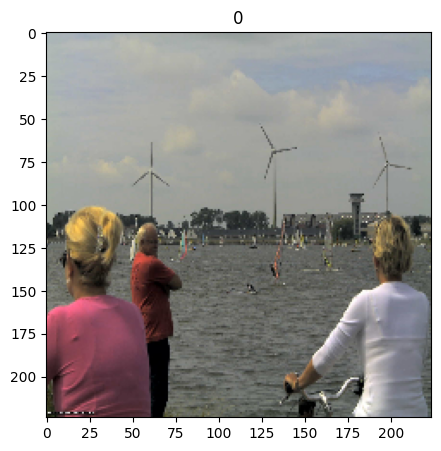

In [7]:
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

In [8]:
%%time

x_train = []
y_train = []
x_test = []
y_test = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in test:
  x_test.append(feature)
  y_test.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255

#print(x_train.shape)
nsamples, nx, ny, ch= x_train.shape
x_train = x_train.reshape((nsamples,ch*nx*ny))

y_train = np.array(y_train)

nsamples, nx, ny, ch= x_test.shape
x_test = x_test.reshape((nsamples,ch*nx*ny))
y_test = np.array(y_test)

CPU times: total: 1.02 s
Wall time: 1 s


In [9]:
from sklearn.model_selection import KFold 
kf = KFold(n_splits=5, random_state=None) 
X= np.concatenate((x_train, x_test), axis=0)
y= np.concatenate((y_train, y_test), axis=0)
for train_index, test_index in kf.split(X):
      print("Train:", train_index, "Validation:",test_index)
      X_train, X_test = X[train_index], X[test_index] 
      y_train, y_test = y[train_index], y[test_index]

Train: [ 329  330  331 ... 1641 1642 1643] Validation: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 

In [10]:
# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 10) 

# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train, y_train)
 
# performing predictions on the test dataset
y_pred = clf.predict(X_test)
 
# metrics are used to find accuracy or error
print()
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))



ACCURACY OF THE MODEL:  0.9512195121951219


In [11]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Accuracy is {0}".format(accuracy_score(y_test, y_pred)))

[[206   4   0]
 [  6  91   0]
 [  1   0  20]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       210
           1       0.96      0.94      0.95        97
           2       1.00      0.95      0.98        21

    accuracy                           0.97       328
   macro avg       0.98      0.96      0.97       328
weighted avg       0.97      0.97      0.97       328

Accuracy is 0.9664634146341463


In [12]:
# Function to perform training with giniIndex.
def train_using_gini(X_train, X_test, y_train):
    # Creating the classifier object
    clf_gini = DecisionTreeClassifier(criterion="gini",
                                      random_state=100, max_depth=3, min_samples_leaf=5)
    # Performing training
    clf_gini.fit(X_train, y_train)
    return clf_gini


# Function to perform training with entropy.
def train_using_entropy(X_train, X_test, y_train):
    # Decision tree with entropy
    clf_entropy = DecisionTreeClassifier(
        criterion="entropy", random_state=100,
        max_depth=3, min_samples_leaf=5)

    # Performing training
    clf_entropy.fit(X_train, y_train)
    return clf_entropy


# Function to make predictions
def prediction(X_test, clf_object):
    # Predicton on test with giniIndex
    y_pred = clf_object.predict(X_test)
    print("Predicted values:")
    print(y_pred)
    return y_pred


# Function to calculate accuracy
def cal_accuracy(y_test, y_pred):
    print("Confusion Matrix: ",
          confusion_matrix(y_test, y_pred))

    print("Accuracy : ",
          accuracy_score(y_test, y_pred) * 100)

    print("Report : ",
          classification_report(y_test, y_pred))

# Driver code
def main():
    # Training and Testing the model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=102)
    
    clf_gini = train_using_gini(X_train, X_test, y_train)
    clf_entropy = train_using_entropy(X_train, X_test, y_train)

    # Operational Phase
    print("Results Using Gini Index:")

    # Prediction using gini
    y_pred_gini = prediction(X_test, clf_gini)
    cal_accuracy(y_test, y_pred_gini)

    print("Results Using Entropy:")
    # Prediction using entropy
    y_pred_entropy = prediction(X_test, clf_entropy)
    cal_accuracy(y_test, y_pred_entropy)


# Calling main function
if __name__ == "__main__":
    main()

Results Using Gini Index:
Predicted values:
[0 2 0 0 0 0 0 0 0 0 0 1 0 2 0 1 0 0 0 0 0 0 0 1 0 0 1 0 2 1 0 0 0 0 0 1 0
 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0
 0 0 2 0 0 0 0 1 1 0 0 0 0 2 2 0 0 0 1 0 0 0 0 0 0 2 0 0 1 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 2 1 2 0 0 0 0 0 0 0 0 0 0 2 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 0
 0 1 2 0 0 0 0 0 1 0 1 0 2 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 2 0 1
 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 2 0 0 0 1 2 2 0 0 0 0 0 1 0 0 1 0]
Confusion Matrix:  [[223   4   7]
 [ 27  55   0]
 [  4   0   9]]
Accuracy :  87.2340425531915
Report :                precision    recall  f1-score   support

           0       0.88      0.95      0.91       234
           1       0.93      0.67      0.78        82
           2       0.

Image classification is the process of assigning classes to images. This is done by finding similar features in images belonging to different classes and using them to identify and label images. 

Image classification is done with the help of neural networks. Neural networks are deep learning algorithms. The below picture shows a neural network.

Neural Networks contain multiple layers of neurons that perform prediction, classification, etc. The output of each neuron is fed to the neurons in the next layer which helps fine-tune the output until we reach the final output layer. The different layers which are present in a neural network are :

- Input Layer: This is the layer through which we give the input to your neural network
- Hidden Layer: This layer contains various neurons which process the input received from the input layer
- Output Layer: The final layer in the network which processes your data one last time and gives you the output

Neural networks can be easily implemented using a deep learning library like Keras, Tensorflow, or Pytorch. 

We are using Keras to implement your Neural Networks. Keras is a Python library that supports other deep learning libraries as backends while providing a user-friendly frontend. It offers strong computational power while maintaining ease of implementation. 

In [13]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import classification_report
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm

In [14]:
class_names = ["0", "1", "2"]
class_names_label = { class_name: i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)

print(class_names_label)
IMAGE_SIZE=(150,150)

{'0': 0, '1': 1, '2': 2}


In [15]:
def load_data():
    DIRECTORY = 'C:/Users/shris/OneDrive/Desktop/MajorProject/KeyFrames'
    CATEGORY =["train", "test"]
    
    output=[]
    
    for category in CATEGORY:
        path = os.path.join(DIRECTORY, category)
        images = []
        labels = []
        
        print("Loading  {}".format(category))
        
        for folder in os.listdir(path):
            label = class_names_label[folder]
            
            #Iterate through each image in our folder
            for file in os.listdir(os.path.join(path,folder)):
                
                img_path = os.path.join(os.path.join(path, folder), file)
                #open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)
            
                #Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')
    
        output.append((images, labels))
        
    return output
    

In [16]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading  train
Loading  test


In [17]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation="relu", input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(3, activation=tf.nn.softmax),
])

In [19]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
history=model.fit(train_images, train_labels, batch_size=128, epochs=6, validation_split=0.2)

Epoch 1/6
9/9 [==============================] - 8s 729ms/step - loss: 314.7747 - accuracy: 0.5071 - val_loss: 9.5033 - val_accuracy: 0.8213
Epoch 2/6
9/9 [==============================] - 6s 668ms/step - loss: 1.8933 - accuracy: 0.8030 - val_loss: 0.3754 - val_accuracy: 0.8973
Epoch 3/6
9/9 [==============================] - 7s 762ms/step - loss: 0.1612 - accuracy: 0.9534 - val_loss: 0.7687 - val_accuracy: 0.8593
Epoch 4/6
9/9 [==============================] - 6s 675ms/step - loss: 0.0754 - accuracy: 0.9724 - val_loss: 0.3888 - val_accuracy: 0.9240
Epoch 5/6
9/9 [==============================] - 6s 713ms/step - loss: 0.0596 - accuracy: 0.9867 - val_loss: 0.4309 - val_accuracy: 0.9392
Epoch 6/6
9/9 [==============================] - 7s 723ms/step - loss: 0.0275 - accuracy: 0.9914 - val_loss: 0.3410 - val_accuracy: 0.9506


In [21]:
def plot_accuracy_loss(history):
    '''
    Plot the accuracy and the loss during the training of nn
    '''
    fig=plt.figure(figsize=(10,5))
    
    #Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'], 'bo--', label="acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label="val_acc")
    plt.title("train_acc vs val_acc")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.legend()
    
    #Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'], 'bo--', label="loss")
    plt.plot(history.history['val_loss'], 'ro--', label="val_loss")
    plt.title("train_loss vs val_loss")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    
    plt.show()

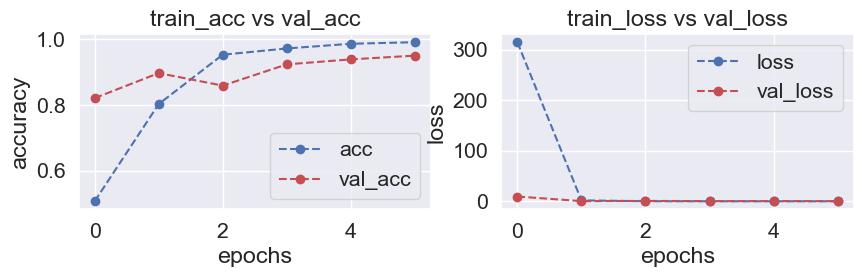

In [22]:
plot_accuracy_loss(history)

In [23]:
test_loss=model.evaluate(test_images,test_labels)

11/11 [==============================] - 1s 62ms/step - loss: 0.1716 - accuracy: 0.9545


In [24]:
predictions=model.predict(test_images)
pred_labels=np.argmax(predictions, axis=1)

11/11 [==============================] - 1s 46ms/step


In [25]:
print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       212
           1       0.98      0.92      0.95        97
           2       0.89      0.81      0.85        21

    accuracy                           0.95       330
   macro avg       0.94      0.90      0.92       330
weighted avg       0.95      0.95      0.95       330



In [26]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

model= VGG16(weights='imagenet', include_top=False)
model= Model(inputs=model.inputs, outputs=model.layers[-5].output)

In [27]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

11/11 [==============================] - 18s 2s/step


In [28]:
from keras.layers import Input, Dense, Conv2D, Activation, MaxPooling2D, Flatten
model2= VGG16(weights="imagenet", include_top=False)

input_shape=model2.layers[-4].get_input_shape_at(0)
layer_input = Input(shape =(9,9,512))

x=layer_input

for layer in model2.layers[-4::1]:
    x=layer(x)
    
x= Conv2D(64, (3, 3), activation='relu')(x)
x= MaxPooling2D(pool_size=(2, 2))(x)
x= Flatten()(x)
x= Dense(100, activation='relu')(x)
x= Dense(3, activation='softmax')(x)

new_model = Model(layer_input, x)

In [29]:
new_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
history= new_model.fit(train_features, train_labels, batch_size=128, epochs=10, validation_split=0.2)

Epoch 1/10
9/9 [==============================] - 23s 2s/step - loss: 6.9896 - accuracy: 0.5680 - val_loss: 13.7387 - val_accuracy: 0.6616
Epoch 2/10
9/9 [==============================] - 22s 2s/step - loss: 3.2171 - accuracy: 0.6185 - val_loss: 1.0902 - val_accuracy: 0.6616
Epoch 3/10
9/9 [==============================] - 23s 3s/step - loss: 2.1729 - accuracy: 0.5814 - val_loss: 1.1471 - val_accuracy: 0.6616
Epoch 4/10
9/9 [==============================] - 22s 2s/step - loss: 1.2610 - accuracy: 0.5814 - val_loss: 1.0640 - val_accuracy: 0.6616
Epoch 5/10
9/9 [==============================] - 22s 2s/step - loss: 1.1809 - accuracy: 0.5937 - val_loss: 0.8022 - val_accuracy: 0.6616
Epoch 6/10
9/9 [==============================] - 22s 2s/step - loss: 1.0282 - accuracy: 0.6394 - val_loss: 1.0277 - val_accuracy: 0.6616
Epoch 7/10
9/9 [==============================] - 22s 2s/step - loss: 1.6057 - accuracy: 0.6394 - val_loss: 1.0122 - val_accuracy: 0.6616
Epoch 8/10
9/9 [=================

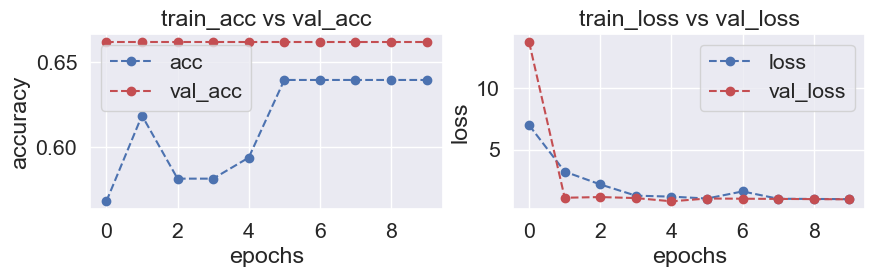

In [31]:
plot_accuracy_loss(history)

Passing the features through SVMClassifier, DecisionTreeClassifier and RandomForestClassifier after reshaping.

In [32]:
nsamples, nx, ny, ch= train_features.shape
train_features = train_features.reshape(nsamples, nx*ny*ch)
nsamples, nx, ny, ch= (test_features.shape)
test_features = test_features.reshape(nsamples, nx*ny*ch)

In [33]:
# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 10) 

# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(train_features, train_labels)
 
# performing predictions on the test dataset
y_pred = clf.predict(test_features)
 
# metrics are used to find accuracy or error
from sklearn import metrics 
print()
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(test_labels, y_pred))



ACCURACY OF THE MODEL:  0.9363636363636364


In [34]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(train_features, train_labels)
y_pred = svclassifier.predict(test_features)

print(confusion_matrix(test_labels, y_pred))
print(classification_report(test_labels, y_pred))
print("Accuracy is {0}".format(accuracy_score(test_labels, y_pred)))

[[212   0   0]
 [  2  95   0]
 [  0   0  21]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       212
           1       1.00      0.98      0.99        97
           2       1.00      1.00      1.00        21

    accuracy                           0.99       330
   macro avg       1.00      0.99      0.99       330
weighted avg       0.99      0.99      0.99       330

Accuracy is 0.9939393939393939


In [35]:
# Function to perform training with giniIndex.
def train_using_gini(X_train, X_test, y_train):
    # Creating the classifier object
    clf_gini = DecisionTreeClassifier(criterion="gini",
                                      random_state=100, max_depth=3, min_samples_leaf=5)
    # Performing training
    clf_gini.fit(X_train, y_train)
    return clf_gini


# Function to perform training with entropy.
def train_using_entropy(X_train, X_test, y_train):
    # Decision tree with entropy
    clf_entropy = DecisionTreeClassifier(
        criterion="entropy", random_state=100,
        max_depth=3, min_samples_leaf=5)

    # Performing training
    clf_entropy.fit(X_train, y_train)
    return clf_entropy


# Function to make predictions
def prediction(X_test, clf_object):
    # Predicton on test with giniIndex
    y_pred = clf_object.predict(X_test)
    print("Predicted values:")
    print(y_pred)
    return y_pred


# Function to calculate accuracy
def cal_accuracy(y_test, y_pred):
    print("Confusion Matrix: ",
          confusion_matrix(y_test, y_pred))

    print("Accuracy : ",
          accuracy_score(y_test, y_pred) * 100)

    print("Report : ",
          classification_report(y_test, y_pred))

# Driver code
def main():

    clf_gini = train_using_gini(train_features, test_features, train_labels)
    clf_entropy = train_using_entropy(train_features, test_features, train_labels)

    # Operational Phase
    print("Results Using Gini Index:")

    # Prediction using gini
    y_pred_gini = prediction(test_features, clf_gini)
    cal_accuracy(test_labels, y_pred_gini)

    print("Results Using Entropy:")
    # Prediction using entropy
    y_pred_entropy = prediction(test_features, clf_entropy)
    cal_accuracy(test_labels, y_pred_entropy)


# Calling main function
if __name__ == "__main__":
    main()

Results Using Gini Index:
Predicted values:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 1 0 0 0 0 0 2 0 0 1
 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 2 2 0 0 0 0 0 1 0 1 1 0 1 0 1 1 1
 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 0 1 1 1 1 1 1 1 2
 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 2 0 2 2 2 2 0 0 0 0 0 2 1 1 1 2 2 2]
Confusion Matrix:  [[191  14   7]
 [  9  85   3]
 [  9   3   9]]
Accuracy :  86.36363636363636
Report :                precision    recall  f1-score   support

           0       0.91      0.90      0.91       212
           1       0.83      0.88      0.85        97
           2      